In [22]:
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
#BiocManager::install("ComplexHeatmap")
# install.packages(c('ClusterR','tidyverse'))
suppressMessages(require(ComplexHeatmap))
suppressMessages(require(tidyverse))
suppressMessages(require(data.table))
require(ClusterR)
require(pracma)

### Kmeans clustering of all data

In [103]:
(dat <- fread('../data_processed/plot_dat.csv') %>%column_to_rownames('V1')) %>%  head(1)
dat %>% dim

,0.5_867451,0.5_867454,0.5_867457,0.5_867478,0.5_867481,0.5_867484,1_926614,1_494014,1_494017,1_494020,⋯,7_685178,7_685217,7_821662,7_823408,7_839434,7_839446,7_833455,7_840319,7_834112,7_995287
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
March1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 10564    74

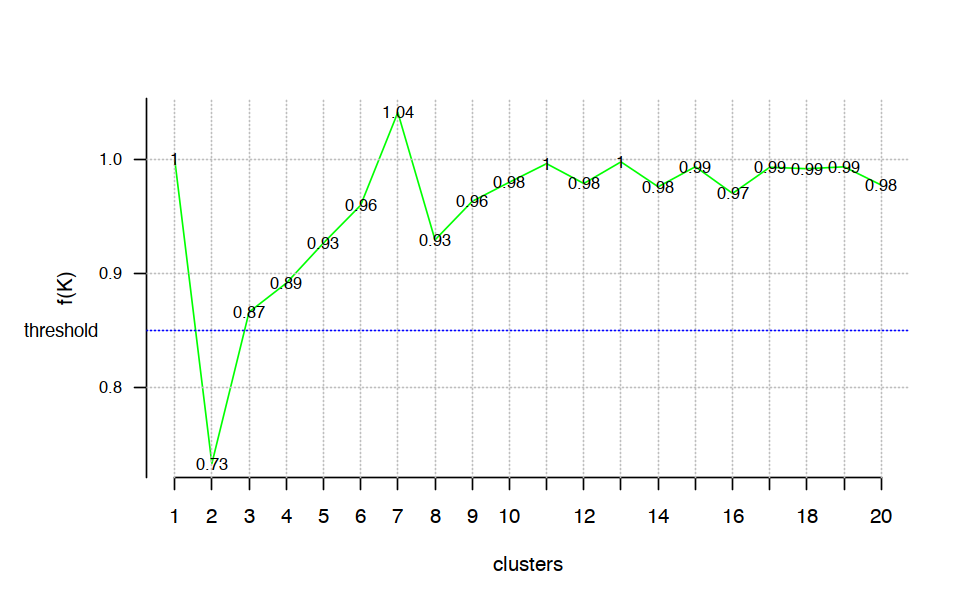

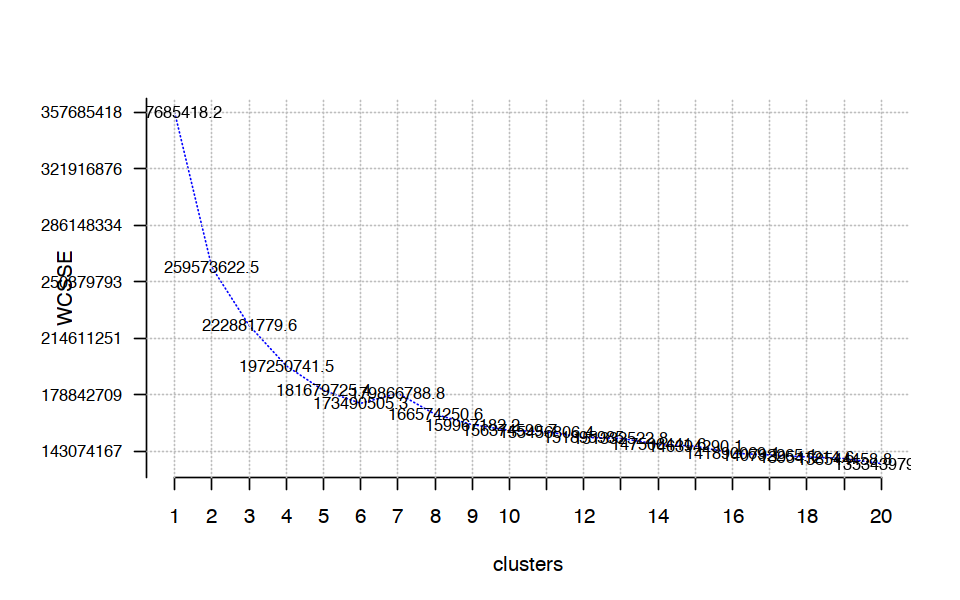

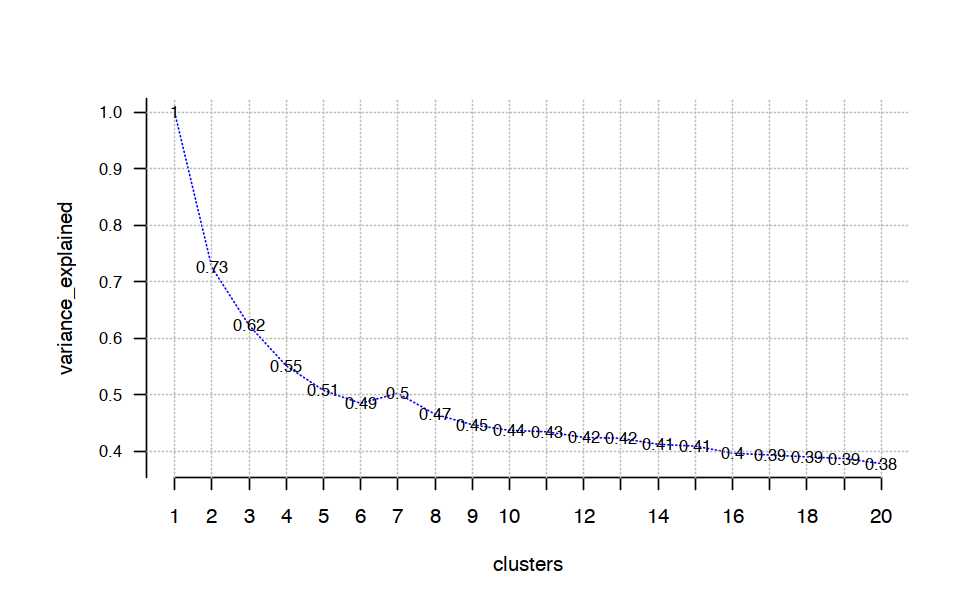

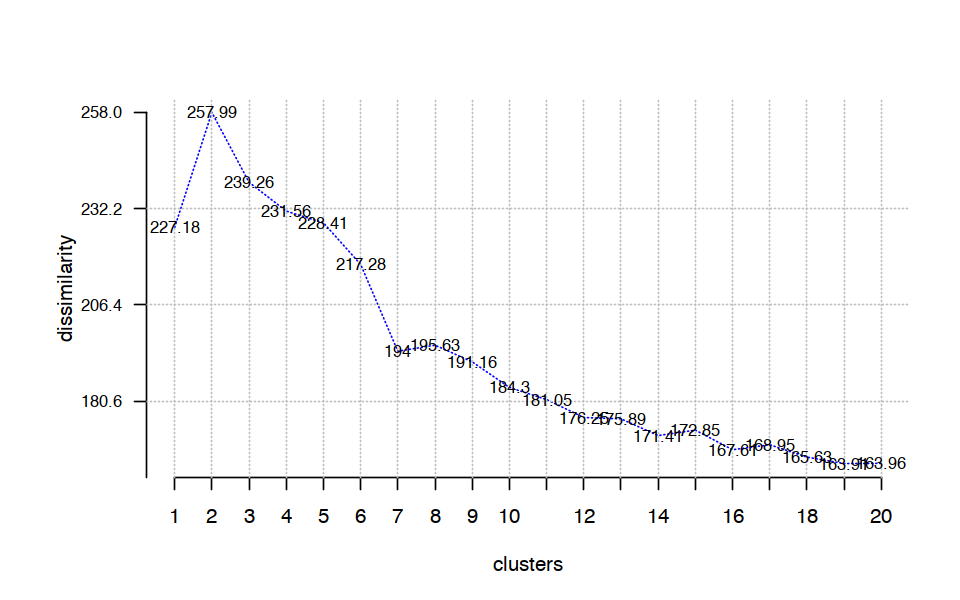

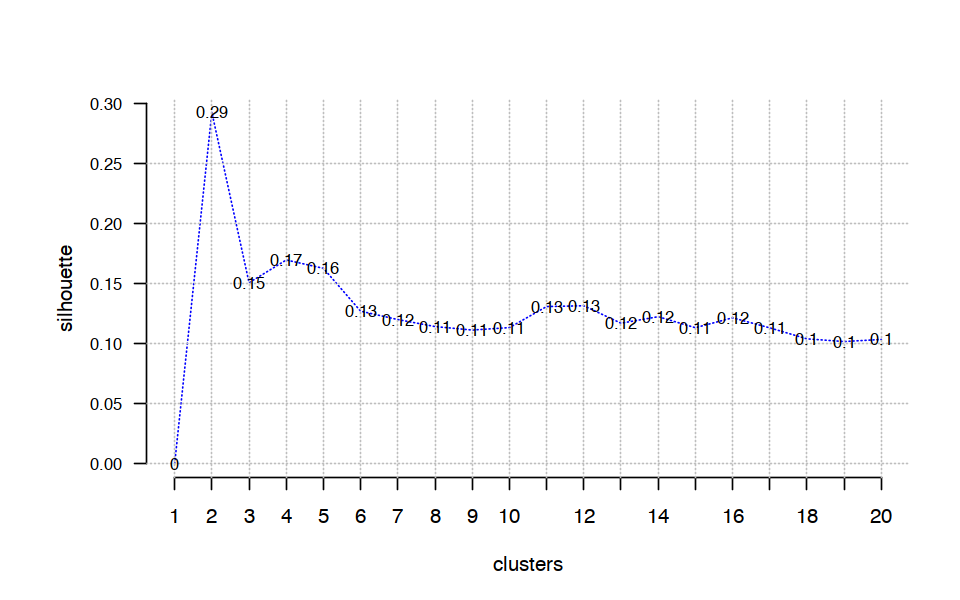

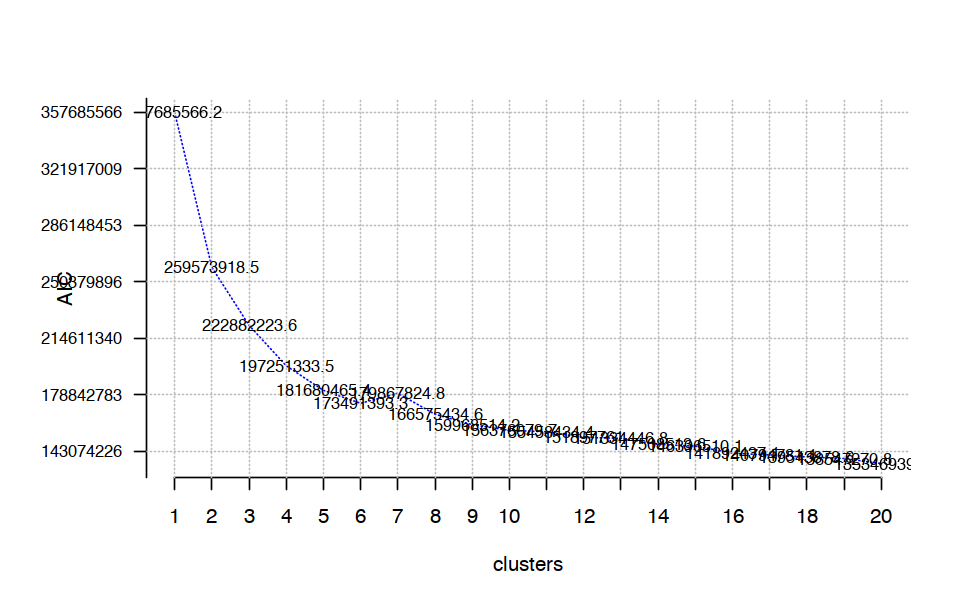

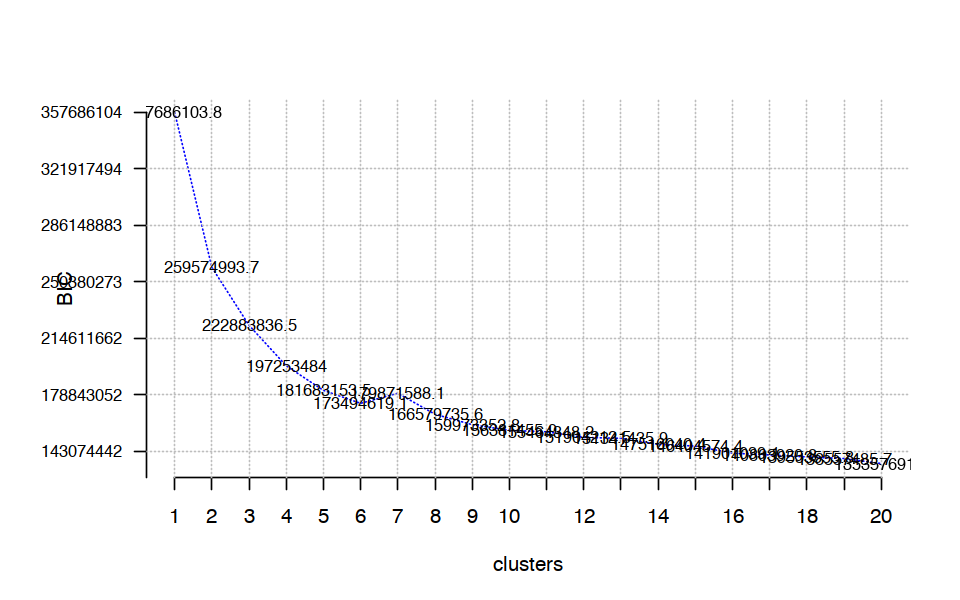

elapsed time is 1616.484000 seconds 


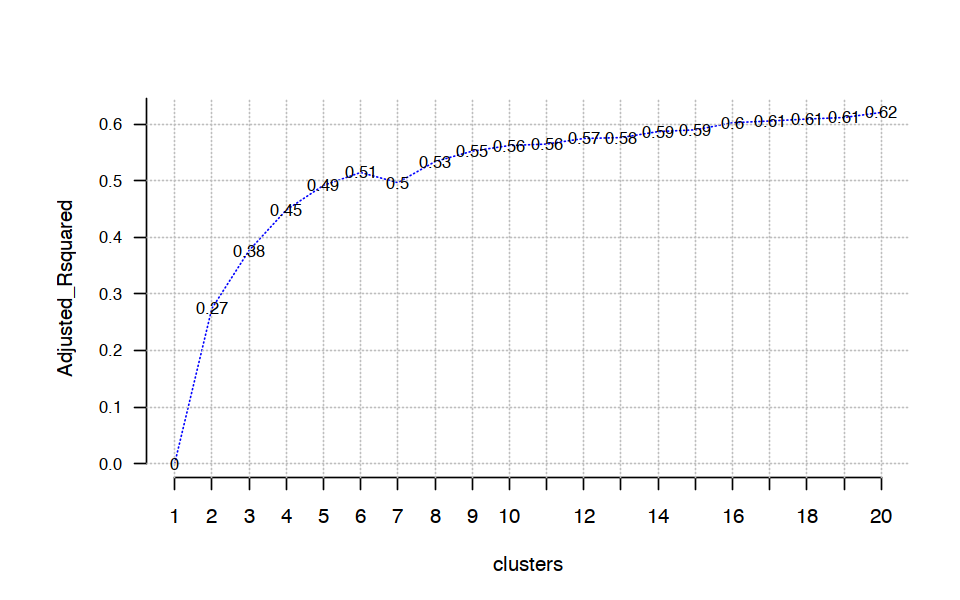

In [108]:
options(repr.plot.width = 8, repr.plot.height = 5)
tic()
for (m in c("distortion_fK", "WCSSE", "variance_explained", "dissimilarity", "silhouette", 
    "AIC", "BIC", "Adjusted_Rsquared")) {
    opt = Optimal_Clusters_KMeans(dat, max_clusters = 20, plot_clusters = T, criterion = m, 
        fK_threshold = 0.85, initializer = "optimal_init", tol_optimal_init = 0.2)
    
}
toc()

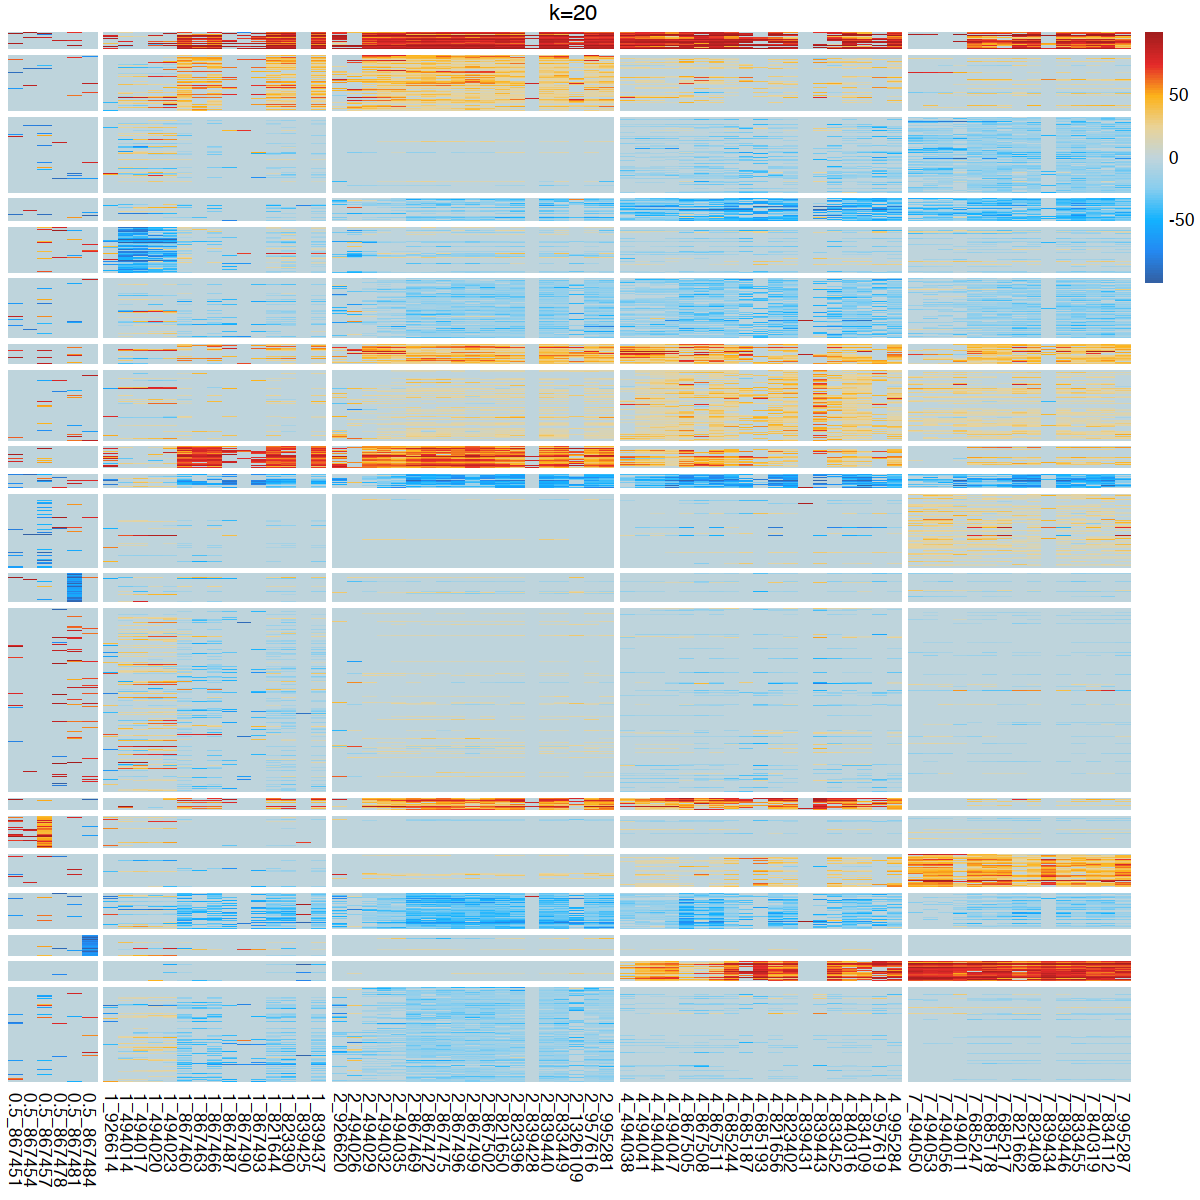

In [127]:
options(repr.plot.width = 10, repr.plot.height = 10)
pal_atac <- colorRampPalette(c("#3361A5", "#248AF3", "#14B3FF", "#88CEEF", "#C1D5DC", 
    "#EAD397", "#FDB31A", "#E42A2A", "#A31D1D"))(100)
doKmeans = function(dat_ = dat, k = 20, ...) {
    km_rc = KMeans_rcpp(dat_, clusters = k, num_init = 5, max_iters = 100, initializer = "optimal_init", 
        verbose = F)
    row.ord <- (dat_ %>% rownames)[order(km_rc$clusters)]
    row.gap <- km_rc$clusters[order(km_rc$clusters)] %>% table %>% cumsum
    col.gap = dat_ %>% colnames %>% sapply(., function(x) (strsplit(x, split = "_") %>% 
        unlist)[1]) %>% table %>% cumsum
    
    pheatmap(dat_[row.ord, ], gaps_row = row.gap, gaps_col = col.gap, scale = "none", 
        color = pal_atac, cluster_rows = F, cluster_cols = F, show_rownames = F, 
        main = paste0("k=", k), ...)
}
doKmeans()

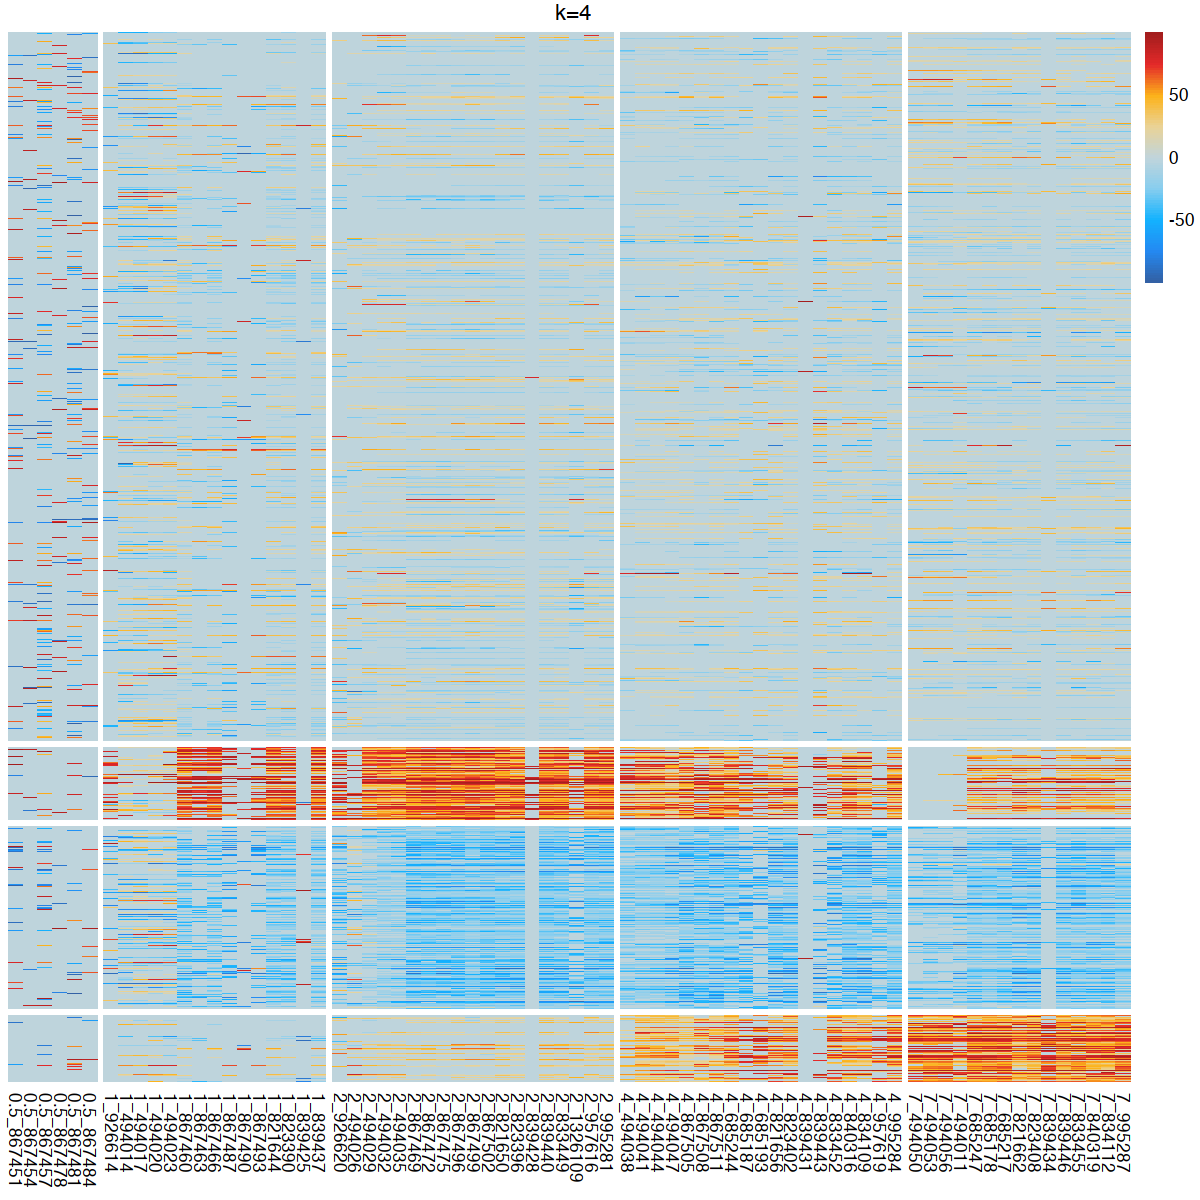

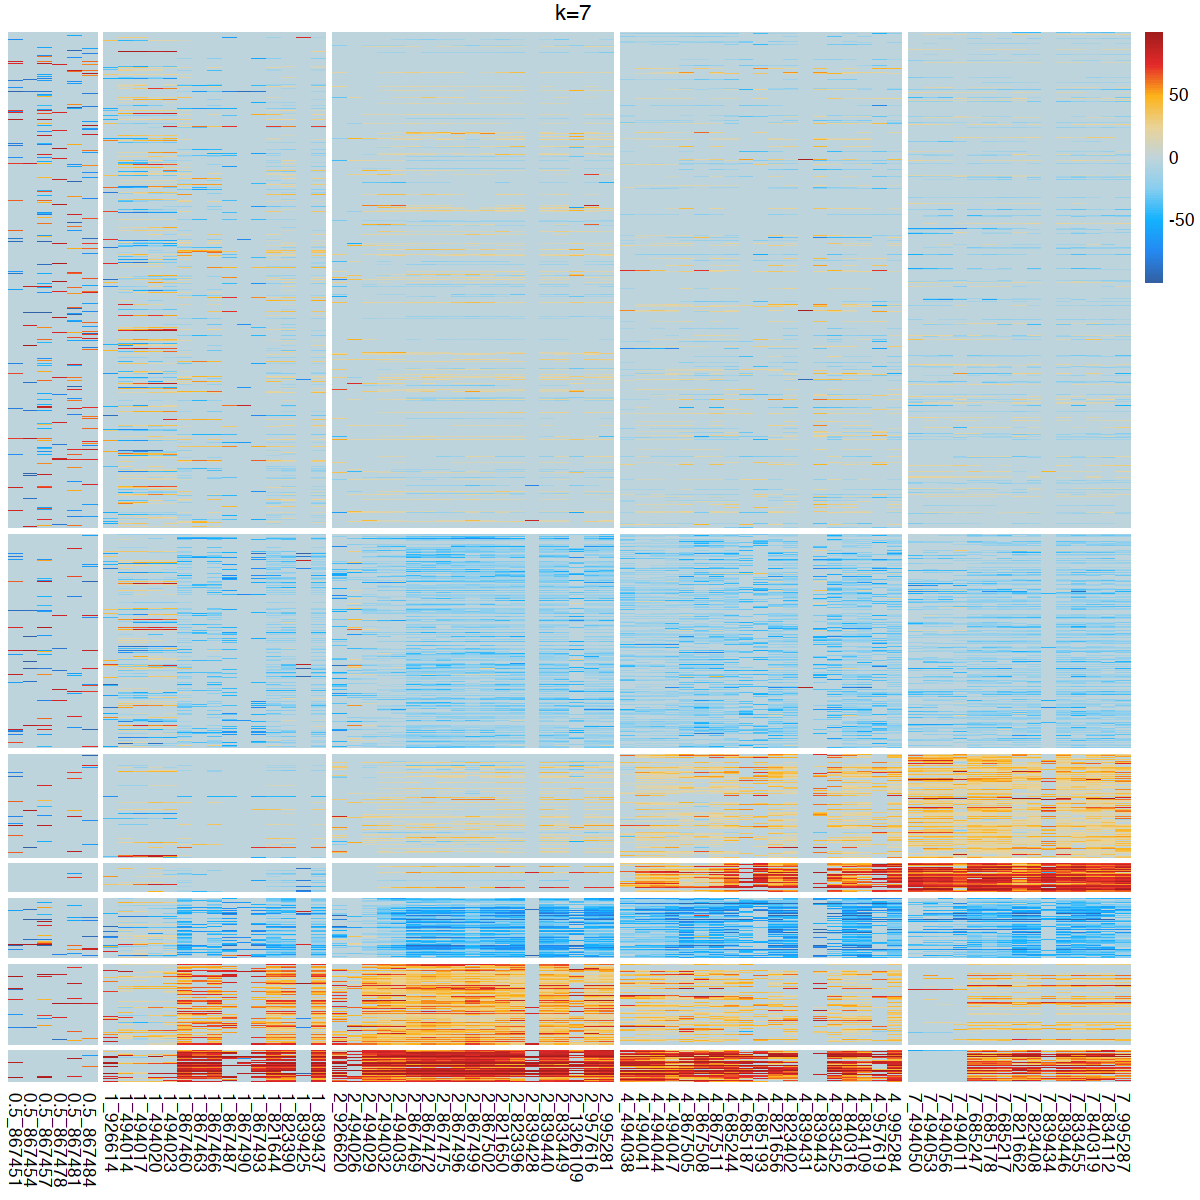

In [128]:
out = doKmeans(k = 4)

In [82]:
pdf(file = "kmeans_init.pdf", width = 10, height = 10)
for (k_ in 4:20) {
    print(k_)
    doKmeans(k = k_)
}
dev.off()
system("open kmeans_init.pdf")

[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20


pdf 
  3

In [96]:
pdf(file = "kmeans_init.pdf", width = 10, height = 10)
print(out)
dev.off()
system("open kmeans_init.pdf")

pdf 
  2

### filter genes

In [159]:
data.frame(mean_abs = apply(dat, 1, mean) %>% abs, sd = row_sd) %>% head

,mean_abs,sd
,<dbl>,<dbl>
March1,11.520322,19.348376
43891,4.826327,12.919225
43892,0.775560,6.671619
March2,3.475095,9.625694
March3,3.752901,9.265672
March5,20.015719,24.156297


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



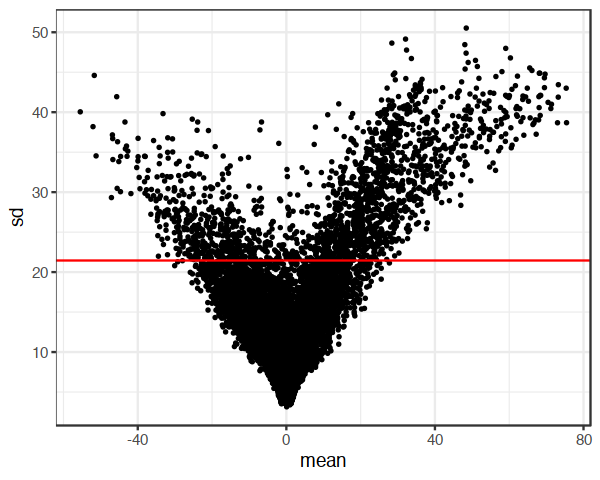

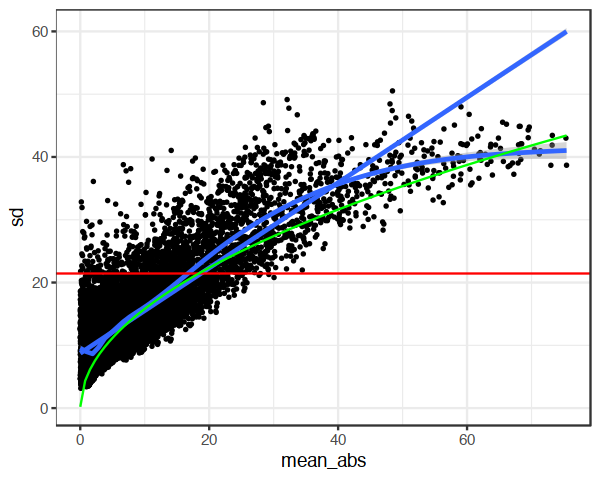

In [171]:
options(repr.plot.width = 5, repr.plot.height = 4)
ggplot(data = data.frame(mean = apply(dat, 1, mean), sd = row_sd)) + geom_point(aes(mean, 
    sd), size = 0.5) + geom_hline(yintercept = dat_sd, color = "red") + theme_bw()

ggplot(data = data.frame(mean_abs = apply(dat, 1, mean) %>% abs, sd = row_sd), aes(x = mean_abs, 
    y = sd)) + geom_point(size = 0.5) + geom_smooth(method = lm) + geom_smooth() + 
    geom_hline(yintercept = dat_sd, color = "red") + geom_function(fun = function(x) 5 * 
    sqrt(x), color = "green") + theme_bw()

In [143]:
dat_sd <- dat %>% flatten %>% unlist %>% sd
(row_sd <- apply(dat,1,sd)) %>% head
table(row_sd>dat_sd)

March1     43891     43892    March2    March3    March5 
19.348376 12.919225  6.671619  9.625694  9.265672 24.156297


FALSE  TRUE 
 8740  1824 

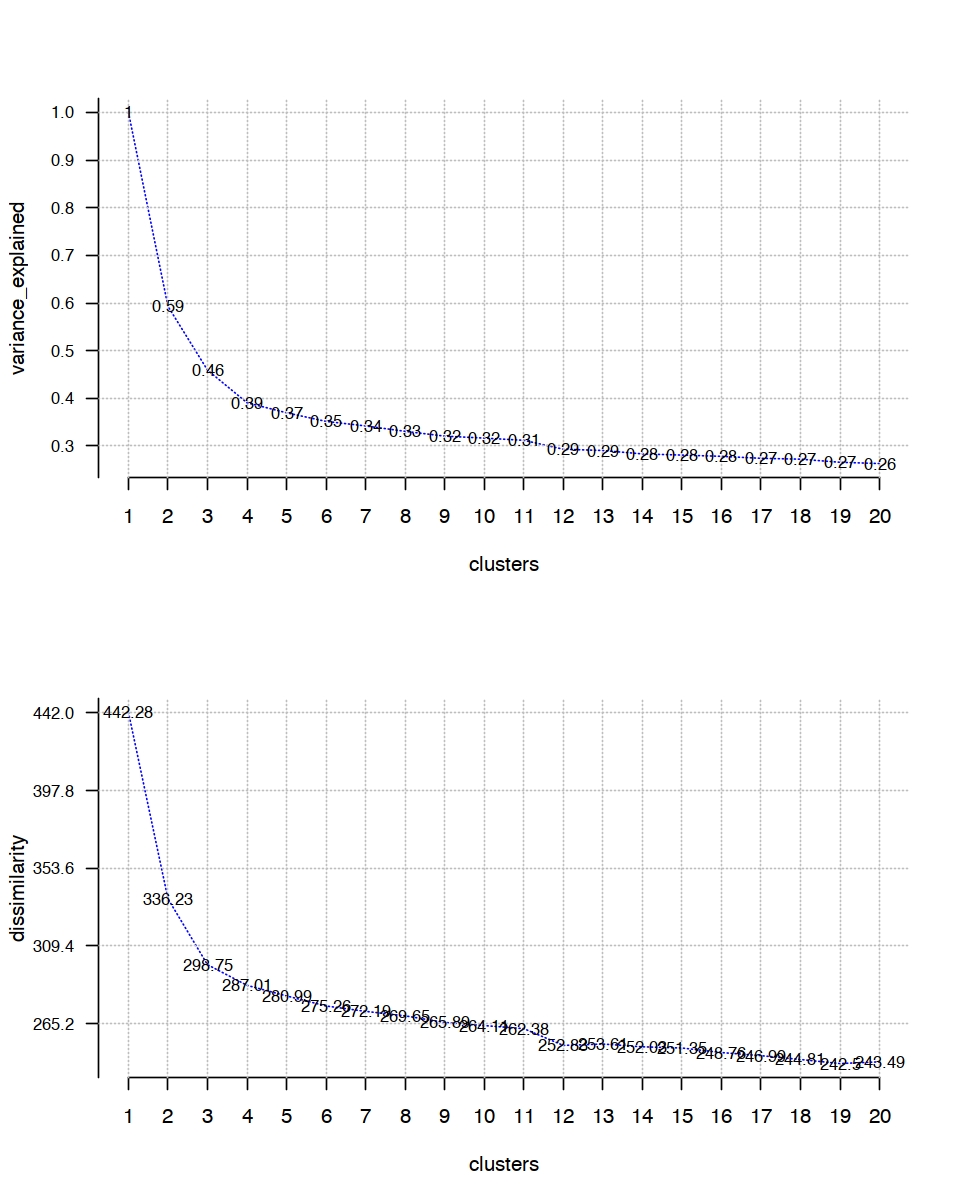

In [148]:
options(repr.plot.width = 8, repr.plot.height = 10)
par(mfrow = c(2, 1))
for (m in c("variance_explained", "dissimilarity")) opt = Optimal_Clusters_KMeans(dat[row_sd > 
    dat_sd, ], max_clusters = 20, plot_clusters = T, criterion = m, fK_threshold = 0.85, 
    initializer = "optimal_init", tol_optimal_init = 0.2)

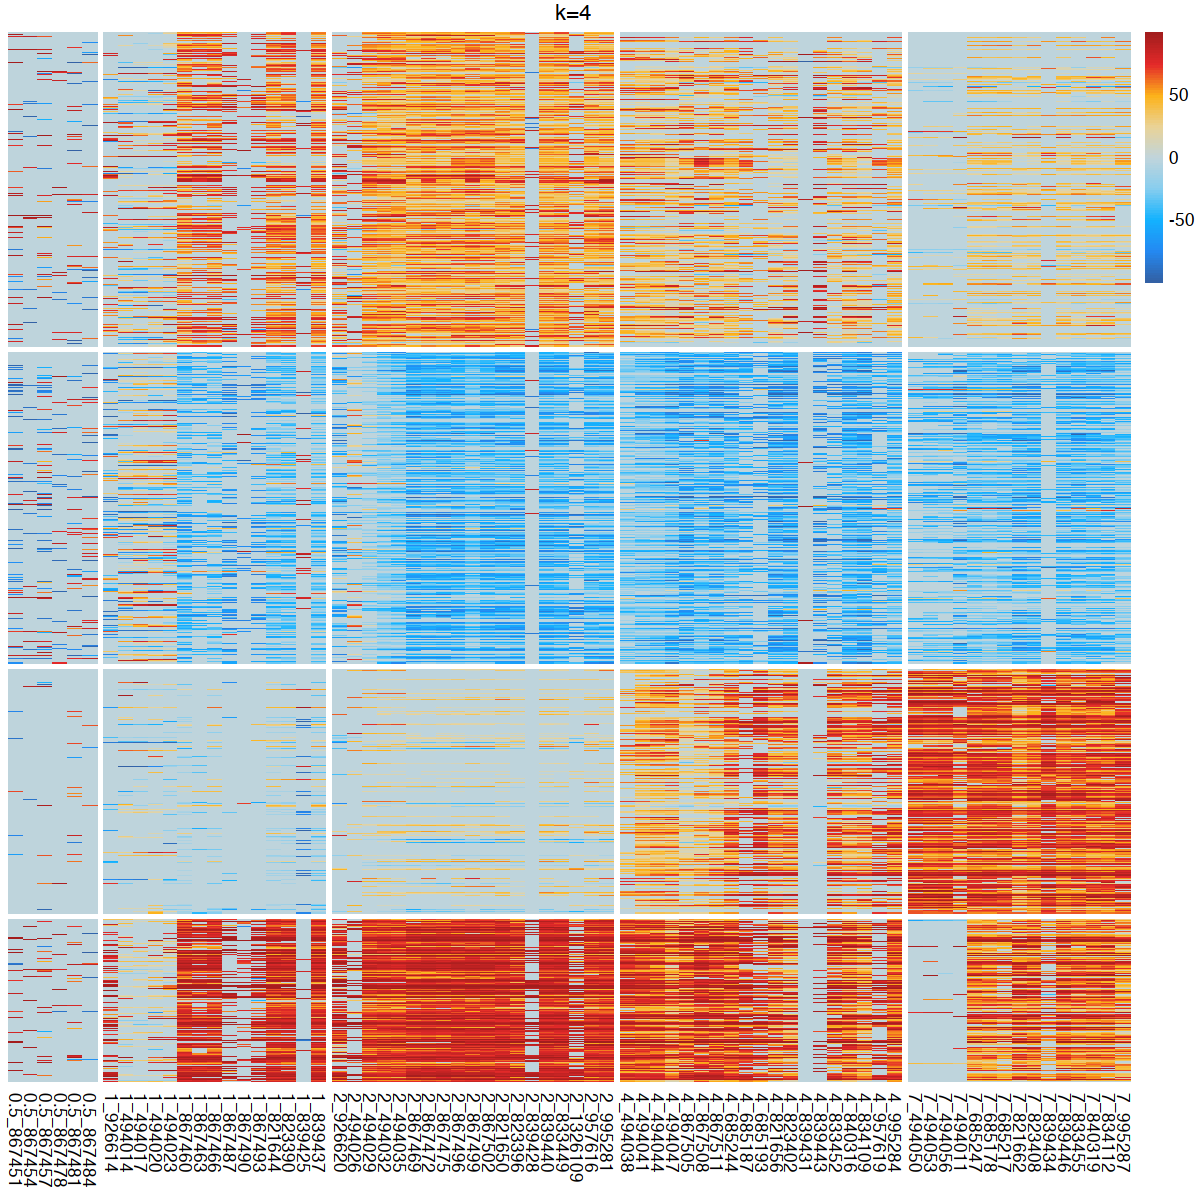

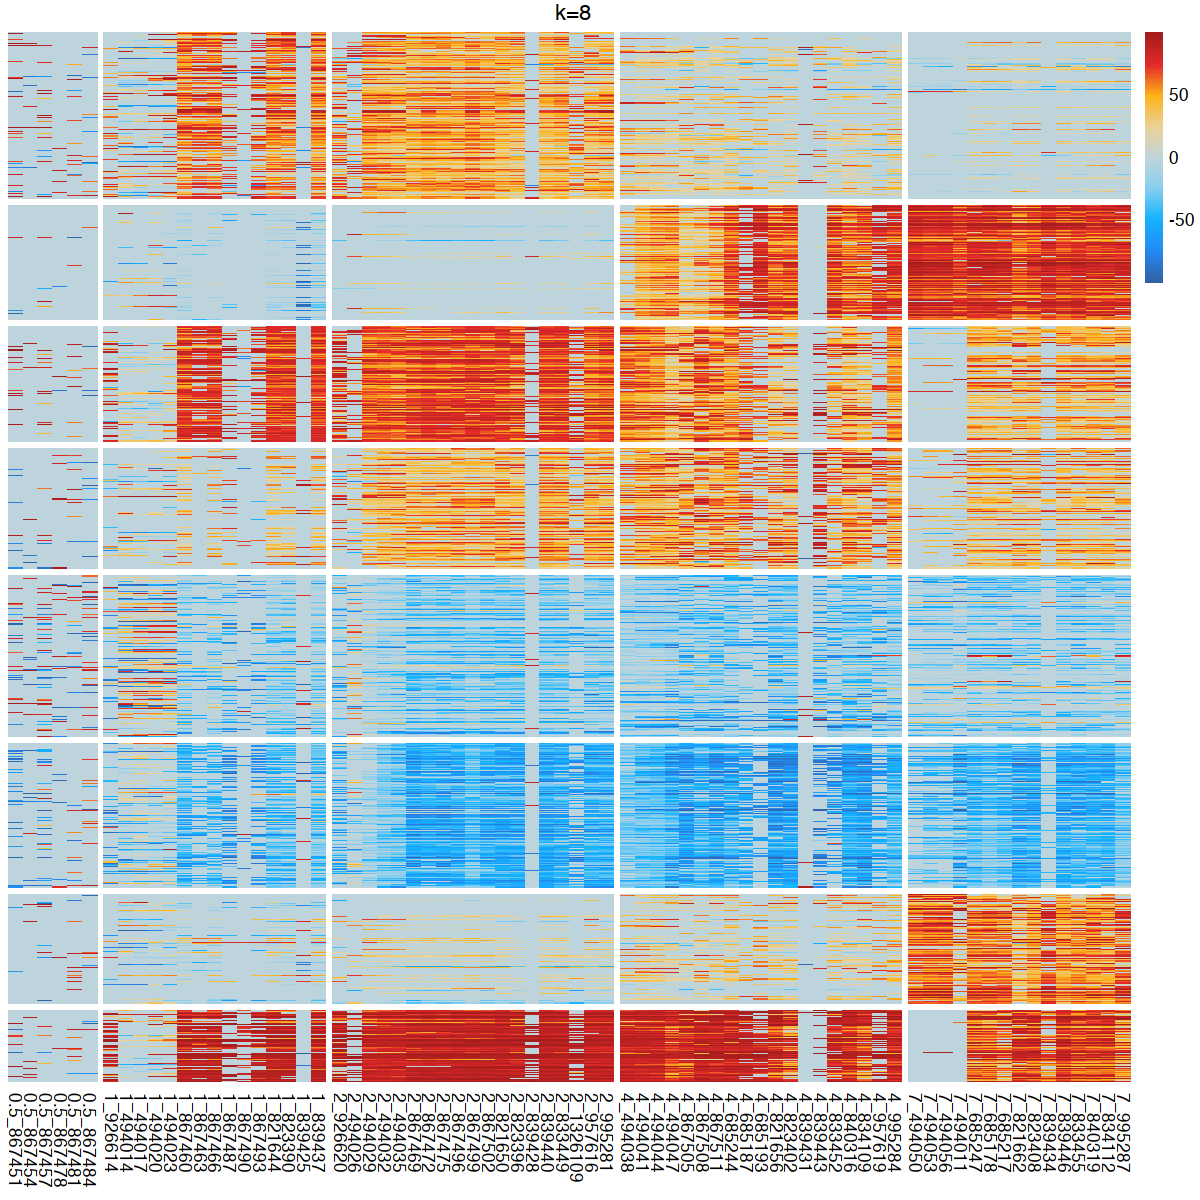

In [151]:
options(repr.plot.width = 10, repr.plot.height = 10)
doKmeans(dat_ = dat[row_sd > dat_sd, ], k = 4)
doKmeans(dat_ = dat[row_sd > dat_sd, ], k = 8)